# Исследование объявлений о продаже квартир

В распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.max_columns = None

In [2]:
df = pd.read_csv('real_estate_data.csv', sep='\t')
print(df.info())
display(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


<b>Вывод</b>

Данные загружены, сделал доступным вывод для просмотра всех столбцов. Обнаружено множество проблем (сразу пишу и их решение).

Типы данных:

- is_apartment в булев
- balcony в int
- first_day_exposition - разделить на год, месяц, день


Пропущенные значения:

- balcony - заполнить 0
- days_exposition - заполнить 0


Нестандарт:

- ceiling_height - не может быть 100, оставим диапазон (1.5, 20)
- locality_name - заменить ё на е для унификации названий


## Предобработка данных

In [3]:
# Работа с пропусками значений и типами данных
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())
df['balcony'] = df['balcony'].fillna(0).astype('int')
df['days_exposition'] = df['days_exposition'].fillna(0)
# Работа с типами данных
df['is_apartment'] = df['is_apartment'].astype('bool')
df['days_exposition'] = df['days_exposition'].astype('int')
#Прочее
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%d')
df['locality_name'] = df['locality_name'].str.replace('ё', 'е', regex=True)

## Расчёты и добавление результатов в таблицу

In [4]:
df['weekday'] = df['first_day_exposition'].dt.weekday
df['month'] = pd.DatetimeIndex(df['first_day_exposition']).month 
df['year'] = pd.DatetimeIndex(df['first_day_exposition']).year

df['price_kv_m'] = df['last_price'] / df['total_area'] # цена квадратного метра

def et(df):
    floor = df['floor']
    flt = df['floors_total']
    if floor == 1:
        return 'Первый'
    if floor == flt:
        return 'Последний'
    return 'Другой'

df['floor2'] = df.apply(et, axis=1)  

df['otnpl_gil_all'] = df['living_area'] / df['total_area'] # соотношение жилой к общей площади
df['otnpl_kuh_all'] = df['kitchen_area'] / df['total_area'] # отношение площади кухни к общей.

## Исследовательский анализ данных

### Изучите следующие параметры: площадь, цена, число комнат, высота потолков. Постройте гистограммы для каждого параметра.

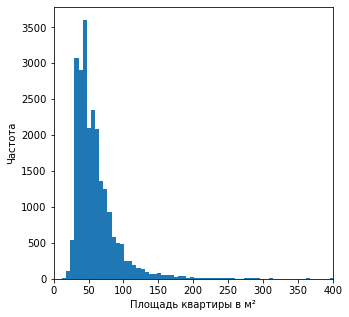

In [5]:
import matplotlib.pyplot as plt

df['total_area'].plot(kind='hist', figsize=(5, 5), bins = 150)
plt.xlim(0, 400)
plt.xlabel('Площадь квартиры в м²')
plt.ylabel('Частота')
plt.show()

Посмотрим на гистограммы, сформированные по каждому параметру.

Площадь - минимум 12 квадратных метров, максимум 900. Эти данные выглядят реальными, кроме квартир больше 300 квадратных метров. По гистограмме видно, что тут нормальное распределение. Больше всего продают квартир площадью до 50 квадратных метров, очень много вариантов квартир от 50 до 100 квадратов.

Text(0, 0.5, 'Частота')

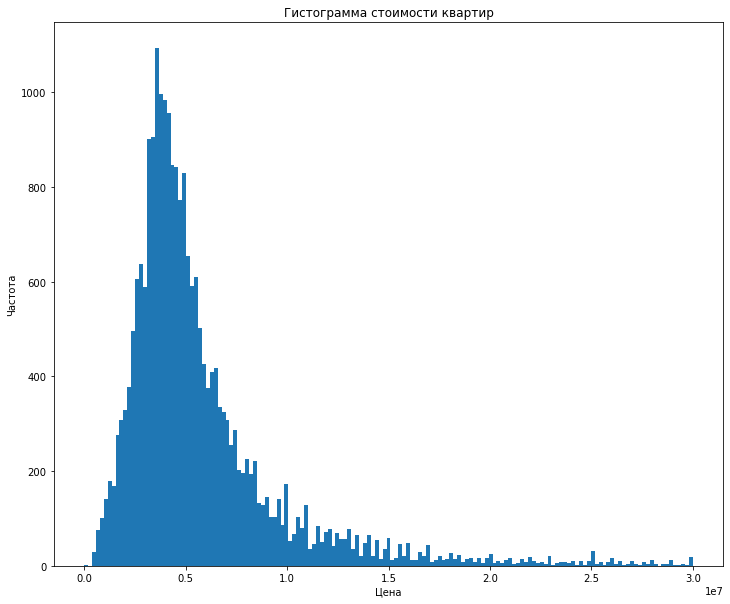

In [6]:
df['last_price'].plot(kind = 'hist', bins=155, range=(0, 30e6), legend = False, figsize=(12,10))
plt.title('Гистограмма стоимости квартир')
plt.xlabel('Цена')
plt.ylabel('Частота')

Цена продажи - 6.5 млн руб среднее значение, нормальное распределение. Есть слишком низкие значения (12000) и очень высокие, надо с этим работать.

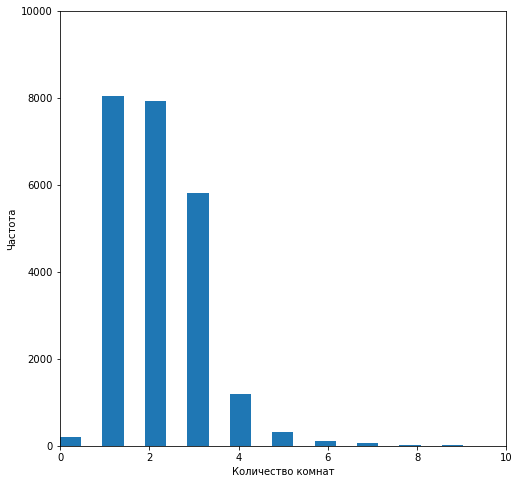

In [7]:
df['rooms'].plot(kind='hist', figsize=(8, 8), bins = 40)
plt.xlim(0, 10)
plt.ylim(0, 10000)
plt.xlabel('Количество комнат')
plt.ylabel('Частота')
plt.show()

Количество комнат - макс. 19 штук, мин. 0 штук, лидеры это квартиры с одной комнатой. При этом на рынке чуть меньше вариантов с двумя комнатами, далее идёт 3 комнаты и так далее, от большего к меньшему.

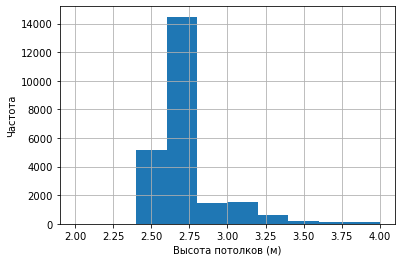

In [8]:
df['ceiling_height'].plot(kind = 'hist', grid = True, range = (2,4))
plt.xlabel('Высота потолков (м)')
plt.ylabel('Частота')
plt.show()

Высота потолков в целом в норме, есть значение равное 100, от такого нужно избавиться.

### Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

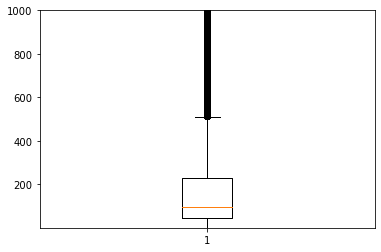

In [9]:
plt.boxplot(df[df['days_exposition']!=0]['days_exposition'])
plt.ylim(1,1000)
plt.show()

Межквартильный размах это 45...232. Диаграмма boxplot показывает, что диаграмма размаха от мин. значения до 500 дней. Нормально продаются квартиры до 500 дней, необычно долго продаются квартиры, которые на рынке более 500 дней.

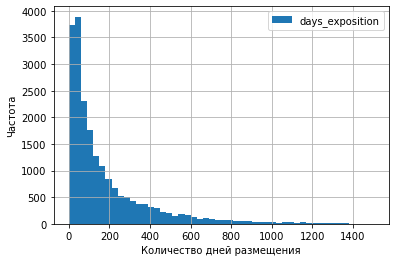

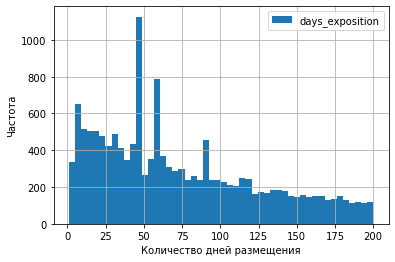

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64


In [10]:
df.plot(y = 'days_exposition', kind = 'hist', bins = 50, grid = True, range = (1,1500))
plt.xlabel('Количество дней размещения')
plt.ylabel('Частота')
plt.show()
df.plot(y = 'days_exposition', kind = 'hist', bins = 50, grid = True, range = (1,200))
plt.xlabel('Количество дней размещения')
plt.ylabel('Частота')
plt.show()

print(df[df['days_exposition']!=0]['days_exposition'].describe())

Основная часть полученных значений лежит в области 0...200, для этого рассмотрим подробнее данный интервал. В нём обнаружены скачки в районе 7, 45, 60, 90 дней. В эти дни чаще всего квартиры продавались (или объявления просто убирались).

Если учесть, что этот интервал идёт каждые 15 дней, значит здесь есть некоторая зависимость, не связанная с продажей квартир.

### Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили.

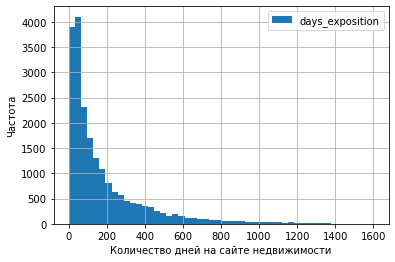

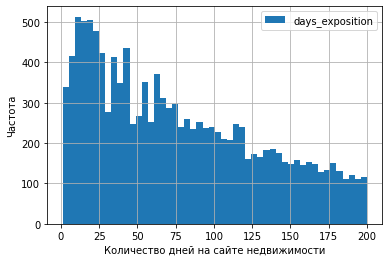

Количество дней размещения, медиана: 74.0
Количество дней размещения, среднее: 156.6
Количество дней размещения, медиана новая: 114.0
Количество дней размещения, среднее новое: 195.8


In [11]:
dfo = df.query('days_exposition != 45 and days_exposition != 30 and days_exposition != 60 and days_exposition != 90 and days_exposition != 7 and days_exposition != 0')

df.plot(y = 'days_exposition', kind = 'hist', bins = 50, grid = True, range = (1,1600))
plt.xlabel('Количество дней на сайте недвижимости')
plt.ylabel('Частота')
plt.show()
dfo.plot(y = 'days_exposition', kind = 'hist', bins = 50, grid = True, range = (1,200))
plt.xlabel('Количество дней на сайте недвижимости')
plt.ylabel('Частота')
plt.show()

print('Количество дней размещения, медиана: {:.1f}'.format(df['days_exposition'].median()))
print('Количество дней размещения, среднее: {:.1f}'.format(df['days_exposition'].mean()))
print('Количество дней размещения, медиана новая: {:.1f}'.format(dfo['days_exposition'].median()))
print('Количество дней размещения, среднее новое: {:.1f}'.format(dfo['days_exposition'].mean()))

Для получения более качественных данных отфильтровал аномалии. Сравним медианы и средние значения до и после.

Убраны пиковые дни. Медианы подсчитаны.

Нормальные значения теперь в диапазоне от 0 до 600 дней.

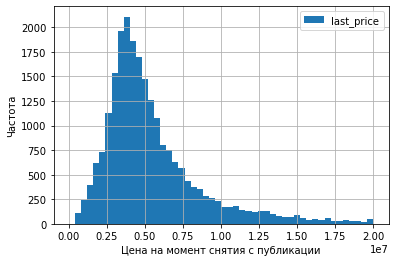

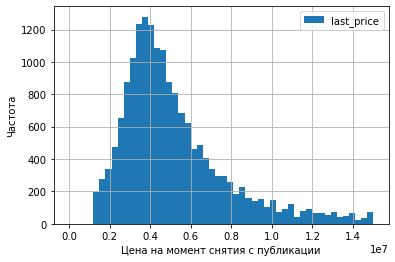

Цена, медиана: 4650000.0
Цена, среднее: 6541548.8
Цена, медиана новая: 4500000.0
Цена, среднее новое: 5149177.0


In [12]:
dfo = dfo.query('last_price <= 1.5e+7 and last_price >= 1.2e+6')

df.plot(y = 'last_price', kind = 'hist', bins = 50, grid = True, range = (0, 2e+7))
plt.xlabel('Цена на момент снятия с публикации')
plt.ylabel('Частота')
plt.show()
dfo.plot(y = 'last_price', kind = 'hist', bins = 50, grid = True, range = (0, 1.5e+7))
plt.xlabel('Цена на момент снятия с публикации')
plt.ylabel('Частота')
plt.show()

print('Цена, медиана: {:.1f}'.format(df['last_price'].median()))
print('Цена, среднее: {:.1f}'.format(df['last_price'].mean()))
print('Цена, медиана новая: {:.1f}'.format(dfo['last_price'].median()))
print('Цена, среднее новое: {:.1f}'.format(dfo['last_price'].mean()))

Цена - сделал диапазон 1,2 млн - 15 млн. Тем самым избавился от ненормальных значений, по среднему это очень заметно.

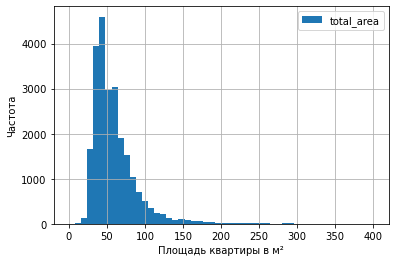

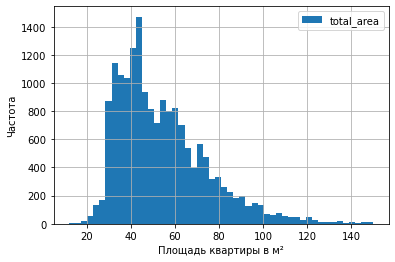

Площадь квартиры в м², медиана: 52.0
Площадь квартиры в м², среднее: 60.3
Площадь квартиры в м², медиана новая: 50.0
Площадь квартиры в м², среднее новое: 54.4


In [13]:
dfo = dfo.query('total_area <= 150')

df.plot(y = 'total_area', kind = 'hist', bins = 50, grid = True, range = (0, 400))
plt.xlabel('Площадь квартиры в м²')
plt.ylabel('Частота')
plt.show()
dfo.plot(y = 'total_area', kind = 'hist', bins = 50, grid = True)
plt.xlabel('Площадь квартиры в м²')
plt.ylabel('Частота')
plt.show()

print('Площадь квартиры в м², медиана: {:.1f}'.format(df['total_area'].median()))
print('Площадь квартиры в м², среднее: {:.1f}'.format(df['total_area'].mean()))
print('Площадь квартиры в м², медиана новая: {:.1f}'.format(dfo['total_area'].median()))
print('Площадь квартиры в м², среднее новое: {:.1f}'.format(dfo['total_area'].mean()))

Площадь - отсеял завышенные и непопулярные площади. Теперь в работе диапазон до 150 квадратных метров.

Самые популярные на рынке это квартиры площадью 50-55 квадратных метров.

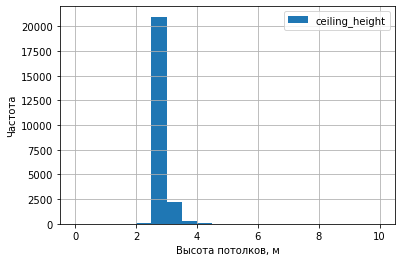

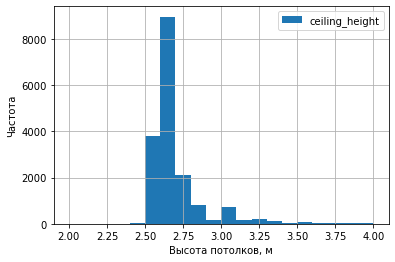

Высота потолков, м, медиана: 2.6
Высота потолков, м, среднее: 2.7
Высота потолков, м, медиана новая: 2.6
Высота потолков, м, среднее новое: 2.7


In [14]:
dfo = dfo.query('ceiling_height <= 4 and ceiling_height >= 2.4')

df.plot(y = 'ceiling_height', kind = 'hist', bins = 20, grid = True, range = (0,10))
plt.xlabel('Высота потолков, м')
plt.ylabel('Частота')
plt.show()
dfo.plot(y = 'ceiling_height', kind = 'hist', bins = 20, grid = True, range = (2,4))
plt.xlabel('Высота потолков, м')
plt.ylabel('Частота')
plt.show()

print('Высота потолков, м, медиана: {:.1f}'.format(df['ceiling_height'].median()))
print('Высота потолков, м, среднее: {:.1f}'.format(df['ceiling_height'].mean()))
print('Высота потолков, м, медиана новая: {:.1f}'.format(dfo['ceiling_height'].median()))
print('Высота потолков, м, среднее новое: {:.1f}'.format(dfo['ceiling_height'].mean()))

Ограничил высоту потолков диапазоном 2,4 м - 4,0 м. Изменений почти нет, избавился от потолка со 100 метрами.

In [15]:
dfo[['last_price', 'total_area','rooms', 'ceiling_height' ]].describe().loc[['min', 'max']]

,last_price,total_area,rooms,ceiling_height
min,1200000.0,12.0,0.0,2.4
max,15000000.0,150.0,7.0,4.0


### Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от площади, числа комнат, удалённости от центра. Изучите зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. Также изучите зависимость от даты размещения: дня недели, месяца и года.

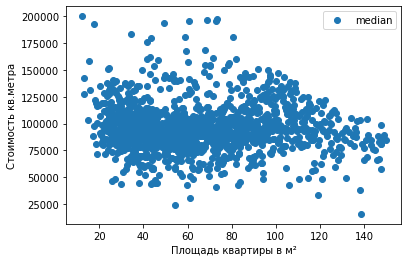

-0.029967585387899877


In [16]:
#Зависимость цены от площади.

zpl = dfo.pivot_table(index = 'total_area', values = 'price_kv_m', aggfunc = ['mean', 'count', 'median'])
zpl.columns = ['mean', 'count', 'median']
zpl.plot(y = 'median', style = 'o', legend = True)
plt.xlabel('Площадь квартиры в м²')
plt.ylabel('Стоимость кв.метра')
plt.show()
zpl.sort_values('median', ascending = False)
print(dfo['total_area'].corr(dfo['price_kv_m']))

Коррелляция получилась в основном очень слабая, разберём по порядку гистаграммы.

Площадь - при росте площади, цена квадратного метра зачастую почти не растёт.

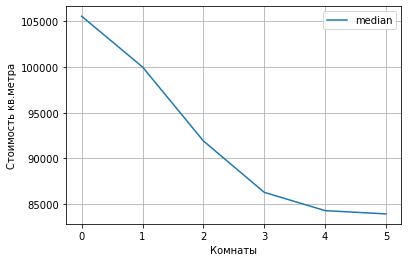

-0.20005144420675958


In [17]:
#Зависимость цены от числа комнат.

zroom = dfo.pivot_table(index = 'rooms', values = 'price_kv_m', aggfunc = ['mean', 'count', 'median'])
zroom.columns = ['mean', 'count', 'median']
zroom.query('count > 20').plot(y = 'median', grid = True, legend = True)
plt.xlabel('Комнаты')
plt.ylabel('Стоимость кв.метра')
plt.show()
zroom.query('count > 20').sort_values('median', ascending = False)
print(dfo['rooms'].corr(dfo['price_kv_m']))

Чем больше комнат в квартире, тем меньше стоимость квадратного метра.

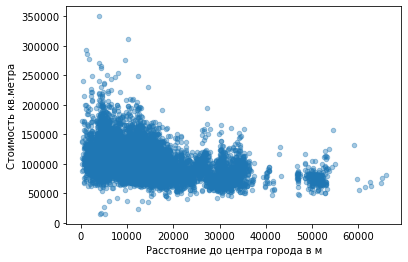

-0.3969398795293054


In [18]:
#Зависимость цены от удалённости от центра.

dfo.plot(kind = 'scatter', y = 'price_kv_m', x = 'cityCenters_nearest', alpha = 0.4)
plt.xlabel('Расстояние до центра города в м')
plt.ylabel('Стоимость кв.метра')
plt.show()
print(dfo['cityCenters_nearest'].corr(dfo['price_kv_m']))

Близость к центру - встречается множество предложений с ценой в 2 раза выше средней, при максимальной близости к центру.

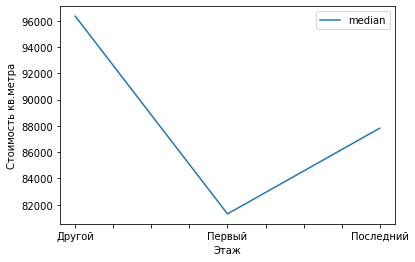

In [19]:
#Зависимость цены от этажа.

zet = dfo.pivot_table(index = 'floor2', values = 'price_kv_m', aggfunc = ['mean', 'count', 'median'])
zet.columns = ['mean', 'count', 'median']
zet.plot(y = 'median', legend = True)
plt.xlabel('Этаж')
plt.ylabel('Стоимость кв.метра')
plt.show()

Этаж - первый этаж классически дешевле, чем остальные. Разница с последним небольшая, около 9%. Помещения на "других" этажах дороже, чем первый или последний.

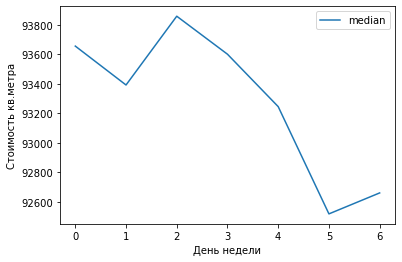

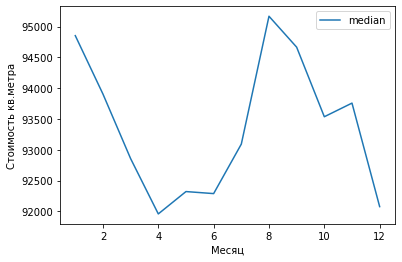

In [20]:
#Зависимость цены от даты размещения.

z_day = dfo.pivot_table(index = 'weekday', values = 'price_kv_m', aggfunc = ['mean', 'count', 'median'])
z_day.columns = ['mean', 'count', 'median']
z_day.plot(y = 'median', legend = True)
plt.xlabel('День недели')
plt.ylabel('Стоимость кв.метра')
plt.show()

#Зависимость стоимости кв. метра от даты размещения: месяца.

z_m = dfo.pivot_table(index = 'month', values = 'price_kv_m', aggfunc = ['mean', 'count', 'median'])
z_m.columns = ['mean', 'count', 'median']
z_m.plot(y = 'median', legend = True)
plt.xlabel('Месяц')
plt.ylabel('Стоимость кв.метра')
plt.show()

День - во вторник самая высокая цена, в субботу самая низкая. Отклонения небольшие.

Месяц - в мае самая низкая цена, в марте самая высокая. После лета к осени цена вновь растёт. Также провал цены наблюдается в районе Нового года. Провал на НГ связан с отсутствием денег у людей под конец и начало года. Летом люди в отпусках и меньше касаются вопросов недвижимости.

(Оставил старые рассуждения, но это наверно можно удалить, раз связи тут нет)

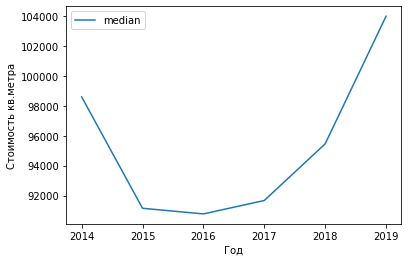

In [21]:
#Зависимость стоимости кв. метра от даты размещения: года.

z_y = dfo.pivot_table(index = 'year', values = 'price_kv_m', aggfunc = ['mean', 'count', 'median'])
z_y.columns = ['mean', 'count', 'median']
z_y.plot(y = 'median', legend = True)
plt.xlabel('Год')
plt.ylabel('Стоимость кв.метра')
plt.show()

Год - 2014 был с высокой стоимостью квадратного метра, затем цена упала к 2016 году, но постепенно идёт резкий рост к 2019 году, который обогнал стоимость кв.метра 2014 года.

### Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите среди них населённые пункты с самой высокой и низкой стоимостью жилья.

In [22]:
ten = dfo.pivot_table(index = 'locality_name', values = 'price_kv_m', aggfunc=['count', 'mean'])
ten.columns = ['count', 'mean']
ten = ten.sort_values('count', ascending = False).head(10)
print(ten)
print('')
print('Самая высокая стоимость жилья')
print((ten[ten['mean'] == ten['mean'].max()]))
print('')
print('Самая низкая стоимость жилья')
print(ten[ten['mean'] == ten['mean'].min()])

                   count           mean
locality_name                          
Санкт-Петербург    11563  105792.624578
поселок Мурино       501   85559.809898
поселок Шушары       359   78209.189630
Всеволожск           301   66770.030597
Колпино              272   75030.974936
Пушкин               269  100854.906807
деревня Кудрово      265   92234.338086
поселок Парголово    260   89972.281555
Гатчина              237   67942.970403
Выборг               170   57822.300021

Самая высокая стоимость жилья
                 count           mean
locality_name                        
Санкт-Петербург  11563  105792.624578

Самая низкая стоимость жилья
               count          mean
locality_name                     
Выборг           170  57822.300021


<b>Вывод</b>

Самая высокая стоимость в ТОП-10 - Санкт-Петербург. Самая низкая стоимость в ТОП-10 это Выборг.

### Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге ('locality_name'). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона.

<ipython-input-23-066edae97d4d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfo['cityCenters_nearest'] = df['cityCenters_nearest'].fillna(30000)
<ipython-input-23-066edae97d4d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfo['cityCenters_nearest'] = dfo['cityCenters_nearest'] / 1000
<ipython-input-23-066edae97d4d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

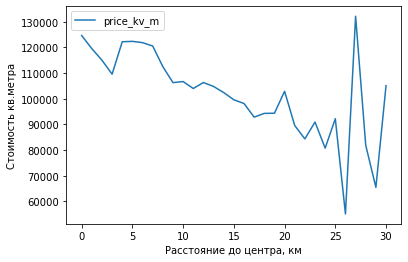

                        price_kv_m
cityCenters_nearest               
0                    124612.740912
1                    119490.529839
2                    114987.889241
3                    109560.803812
4                    122177.168394
5                    122333.988439
6                    121836.052501
7                    120523.887984
8                    112480.011209
9                    106259.173353
10                   106676.699822
11                   103967.505313
12                   106303.092063
13                   104765.288303
14                   102384.968591
15                    99575.287249
16                    98127.611864
17                    92815.795886
18                    94279.385751
19                    94335.523049
20                   102874.291970
21                    89561.773179
22                    84339.420318
23                    90910.749407
24                    80746.335837
25                    92206.835864
26                  

In [23]:
dfo['cityCenters_nearest'] = df['cityCenters_nearest'].fillna(30000)
dfo['cityCenters_nearest'] = dfo['cityCenters_nearest'] / 1000
dfo['cityCenters_nearest'] = dfo['cityCenters_nearest'].astype('int')
dfSPB = dfo.query('locality_name == "Санкт-Петербург"').pivot_table(index = 'cityCenters_nearest', values = 'price_kv_m', aggfunc = 'mean')
dfSPB.plot(y = 'price_kv_m', legend = True)
plt.xlabel('Расстояние до центра, км')
plt.ylabel('Стоимость кв.метра')
plt.show()
print(dfSPB)

<b>Вывод</b>

Выделим радиус 3 км как центральную зону.

### Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?

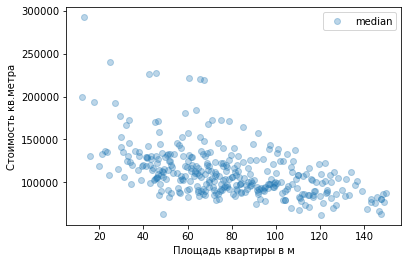

,mean,count,median
total_area,,,
13.0,292307.692308,1,292307.692308
25.0,240000.040000,1,240000.040000
45.7,227571.115974,1,227571.115974
42.7,226440.281030,2,226440.281030
60.6,221122.112211,1,221122.112211
...,...,...,...
110.6,67811.934901,1,67811.934901
147.0,66666.666667,1,66666.666667
48.8,63524.590164,1,63524.590164


In [24]:
cspb = dfo.query('cityCenters_nearest <= 3 and locality_name == "Санкт-Петербург"')

#Зависимость стоимости кв. метра от площади.

cspb_zpl = cspb.pivot_table(index = 'total_area', values = 'price_kv_m', aggfunc = ['mean', 'count', 'median'])
cspb_zpl.columns = ['mean', 'count', 'median']
cspb_zpl.plot(y = 'median', style = 'o', legend = True, alpha = 0.3)
plt.xlabel('Площадь квартиры в м')
plt.ylabel('Стоимость кв.метра')
plt.show()
cspb_zpl.sort_values('median', ascending = False)

Вновь взглянем на гистограммы.

Площадь - нет отличий от выводов по всему городу. От увеличения площади стоимость квадратного метра не растёт. В целом цена квадратного метра в центре выше, чем по всему городу.

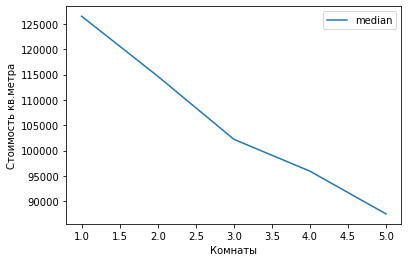

,mean,count,median
rooms,,,
1,139602.803393,80,126521.950036
2,120887.220969,232,114680.671254
3,108384.534391,213,102228.047182
4,98741.012786,99,95931.882687
5,90497.612506,42,87492.182614


In [25]:
#Зависимость стоимости кв. метра от количества комнат.

cspb_rooms = cspb.pivot_table(index='rooms', values='price_kv_m', aggfunc=['mean', 'count', 'median'])
cspb_rooms.columns = ['mean', 'count', 'median']
cspb_rooms.query('count > 20').plot(y = 'median', legend = True)
plt.xlabel('Комнаты')
plt.ylabel('Стоимость кв.метра')
plt.show()
cspb_rooms.query('count > 20').sort_values('median', ascending = False)

Комнаты - квартиры с 5 комнатами имеют наименьшую цену квадратного метра. Отличия от прошлого случая, лишь в стоимости квадратного метра - здесь она выше.

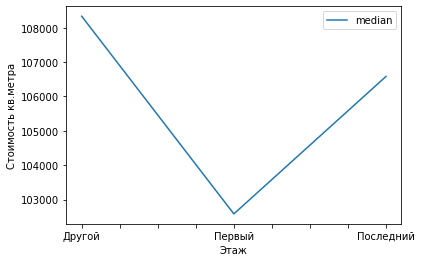

In [26]:
#Зависимость стоимости кв. метра от этажа.

cspb_et = cspb.pivot_table(index = 'floor2', values = 'price_kv_m', aggfunc = ['mean', 'count', 'median'])
cspb_et.columns = ['mean', 'count', 'median']
cspb_et.plot(y = 'median', legend = True)
plt.xlabel('Этаж')
plt.ylabel('Стоимость кв.метра')
plt.show()

Этаж - особых отличий нет, первый этаж самый доступный по цене. Последний в центре намного ближе по цене к самому дорогому из других, чем в остальном городе.

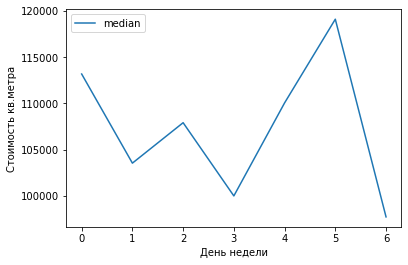

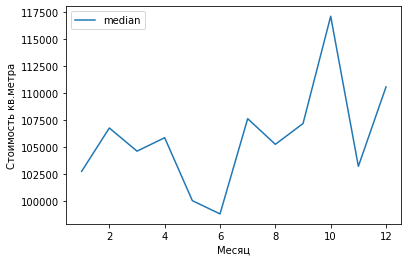

In [27]:
#Зависимость стоимости кв. метра от даты размещения: дня недели.

cspb_day = cspb.pivot_table(index = 'weekday', values = 'price_kv_m', aggfunc = ['mean', 'count', 'median'])
cspb_day.columns = ['mean', 'count', 'median']
cspb_day.plot(y = 'median')
plt.xlabel('День недели')
plt.ylabel('Стоимость кв.метра')
plt.show()

#Зависимость стоимости кв. метра от даты размещения: месяца.

cspb_m = cspb.pivot_table(index = 'month', values = 'price_kv_m', aggfunc = ['mean', 'count', 'median'])
cspb_m.columns = ['mean', 'count', 'median']
cspb_m.plot(y = 'median')
plt.xlabel('Месяц')
plt.ylabel('Стоимость кв.метра')
plt.show()

День - ситуация отличается на 180 градусов от прошлого вывода по дням, в будни цены ниже, к выходным повышаются. Вторник - самые низкие цены, воскресенье - самые высокие.

Месяц - подъём в начале весны, спад к лету, подъём к осени, спад после НГ. Похоже на ситуацию во всём городе, кроме резких скачков в феврале-апреле.

(Просто оставил старый вывод, смысла рассматривать это нет)

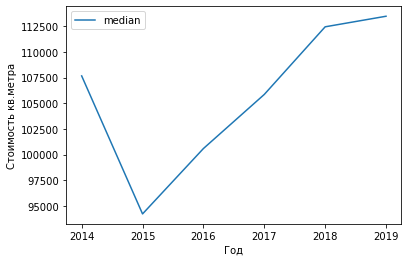

In [28]:
#Зависимость стоимости кв. метра от даты размещения: года.

cspb_y = cspb.pivot_table(index = 'year', values = 'price_kv_m', aggfunc = ['mean', 'count', 'median'])
cspb_y.columns = ['mean', 'count', 'median']
cspb_y.plot(y = 'median', legend = True)
plt.xlabel('Год')
plt.ylabel('Стоимость кв.метра')
plt.show()

Нет отличий от выводов по всему городу. Резкий обвал цен в 2015, затем постепенный подъём, и новый рекорд цены квадратного метра в 2019.

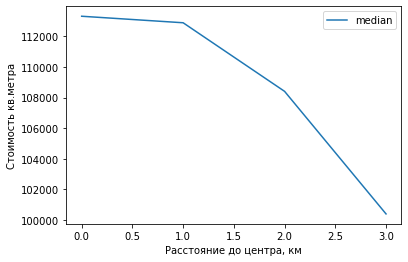

In [29]:
#Зависимость стоимости кв. метра от удалённости от центра.

cspb_uc = cspb.pivot_table(index = 'cityCenters_nearest', values = 'price_kv_m', aggfunc = ['mean', 'count', 'median'])
cspb_uc.columns = ['mean', 'count', 'median']
cspb_uc.plot(y = 'median', legend = True)
plt.xlabel('Расстояние до центра, км')
plt.ylabel('Стоимость кв.метра')
plt.show()

Близость к центру - чем ближе к центру, тем дороже.

## Общий вывод

Обработана информация о рынке недвижимости. Проведена оценка насколько влияют различные факторы на цену квадратного метра.

- Самая высокая стоимость жилья в Санкт-Петербурге. Самая низкая в Выборге (ТОП-10 населённых пунктов с наибольшим числом объявлений)
- Область входящая в центр равняется радиусу 3 километров.
- В 2014 году была высокая цена, которая упала к 2016 году, затем постепенно начался рост и к 2019 году стоимость стала больше, чем в 2014 году.
- Первый этаж имеет самую низкую цену. По городу около 80000 за кв.м., в центре 100000 за кв.м.
- Последний этаж стоит дороже, чем первый, но зачастую дешевле, чем остальные другие этажи. По городу 88000 за кв.м., в центре 106500 за кв.м.
- Цена стоимости квадратного метра падает при увеличении числа комнат. Ситуация по центру: 1 комната - 125000 за кв.м., 5 комнат - 90000 за кв.м. Остальной город: 0-1 комната - около 105000 за кв.м., 5 комнат - около 85000 за кв.м. В центре нет предложений с "0" комнат.
- Высота потолков в среднем составляет 2,7 метра.
- Продажа квартиры считается очень долгой, если объявление держится более 500 дней.
- Ситуация на рынке недвижимости в центре частично отличается от всего города. Стоимость квадратного метра становится выше, чем ближе находится квартира к центру города.